<a href="https://colab.research.google.com/github/e-albuquerque/BEM2D_Iso_SubReg/blob/master/ContactMechanics2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de um problema de contato usando o Fenics


## Código original disponível em:

https://comet-fenics.readthedocs.io/en/latest/demo/contact/penalty.html

In [1]:
!apt-get install software-properties-common
!add-apt-repository -y ppa:fenics-packages/fenics
!apt-get update
!apt-get install --no-install-recommends fenics 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
software-properties-common is already the newest version (0.96.24.32.14).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://ppa.launchpad.net/fenics-packages/fenics/ubuntu bionic InRelease [15.4 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB

In [70]:
import fenics as fn
import numpy as np
import mshr as msh

In [75]:
rec1=msh.Rectangle(fn.Point(0, 1), fn.Point(1, 2))
rec2=msh.Rectangle(fn.Point(-1, 0), fn.Point(0, 2))
circ = msh.Circle(fn.Point(0, 1), 1)
g2d=circ-rec1-rec2
mesh = msh.generate_mesh(g2d, 10)

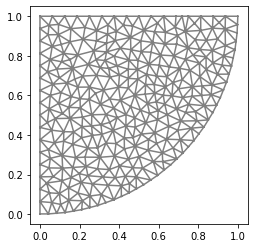

In [76]:
fn.plot(mesh)

In [46]:
class Top(fn.SubDomain):
    def inside(self, x, on_boundary):
        return fn.near(x[1], 0.) and on_boundary
def symmetry_x(x, on_boundary):
        return fn.near(x[0], -1.) and on_boundary
def symmetry_y(x, on_boundary):
        return fn.near(x[1], -1.) and on_boundary

# exterior facets MeshFunction
facets = fn.MeshFunction("size_t", mesh, 2)
facets.set_all(0)
Top().mark(facets, 1)
ds = fn.Measure('ds', subdomain_data=facets)

In [47]:
# R = 0.5
d = 0.02
# obstacle = fn.Expression("-d+pow(x[0],2)/2/R", d=d, R=R, degree=2)
obstacle = fn.Expression("-d", d=d, degree=1)

V = fn.VectorFunctionSpace(mesh, "CG", 1)
V2 = fn.FunctionSpace(mesh, "CG", 1)
V0 = fn.FunctionSpace(mesh, "DG", 0)

u = fn.Function(V, name="Displacement")
du = fn.TrialFunction(V)
u_ = fn.TestFunction(V)

bc =[fn.DirichletBC(V.sub(0), fn.Constant(0.), symmetry_x),
     fn.DirichletBC(V.sub(1), fn.Constant(0.), symmetry_y)]

In [48]:
E = fn.Constant(10.)
nu = fn.Constant(0.3)
mu = E/2/(1+nu)
lmbda = E*nu/(1+nu)/(1-2*nu)
def eps(v):
    return fn.sym(fn.grad(v))
def sigma(v):
    return lmbda*fn.tr(eps(v))*fn.Identity(2) + 2.0*mu*eps(v)
def ppos(x):
    return (x+np.abs(x))/2.

pen = fn.Constant(1e2)
form = fn.inner(sigma(u), eps(u_))*fn.dx + pen*fn.dot(u_[1], ppos(u[1]-obstacle))*fn.ds(1)
J = fn.derivative(form, u, du)

In [49]:
problem = fn.NonlinearVariationalProblem(form, u, bc, J=J)
solver = fn.NonlinearVariationalSolver(problem)
solver.parameters["newton_solver"]["linear_solver"] = "cg"
solver.parameters["newton_solver"]["preconditioner"] = "ilu"
solver.solve()

(0, True)

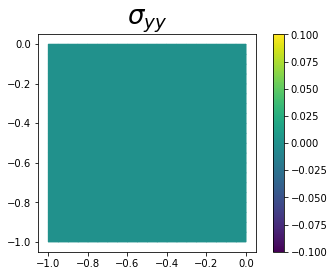

In [43]:

import matplotlib.pyplot as plt
p = fn.plot(sigma(u)[1,1], mode='color') 

plt.colorbar(p)
plt.title(r"$\sigma_{yy}$",fontsize=26)
plt.show()